In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from data_frame import getDataFrame
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from model_resnet9 import ResNet9
import torchvision
from skimage.morphology import skeletonize

In [3]:
train_df = getDataFrame()
train_df = train_df[:5850]

In [4]:
BATCH = 32
EPOCHS = 10
LR = 0.01
IM_SIZE = 256

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.CenterCrop(500),
    transforms.Resize((IM_SIZE, IM_SIZE))
    ])

alter_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=(0, 180), translate=(0.05, 0.1)),
    transforms.CenterCrop(666),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((IM_SIZE, IM_SIZE))
])

In [5]:
def split_indices(n, val_pct=0.25, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [6]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values
train_indices, val_indices = split_indices(len(X_Train))

class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        # x = Image.open(self.fnames[index])
        img = cv2.imread(self.fnames[index])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Edge detection with sobel filters
        blur = cv2.GaussianBlur(gray, (3,3), 0)
        edge = cv2.Sobel(blur, cv2.CV_64F, 1, 1, ksize=5)
        mask = cv2.inRange(edge, (-1000000), (0))
        edge[mask>0] = 0
        mask2 = cv2.inRange(edge,(255), (1000000))
        edge[mask2>0] = 255
        edge = edge.astype(np.uint8)
        
        kernel = np.ones((5,5), np.uint8)
        img_dilation = cv2.dilate(edge, kernel, iterations=1)
        biedge = img_dilation.astype(float)/255
        biedge = biedge.astype(np.uint8)  
        skel = skeletonize(biedge)
        skel = (skel*255).astype(np.uint8)
        
        x = cv2.merge((edge,skel))
        if "train" in self.fnames[index]:             
            return self.transform(edge), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(edge), self.fnames[index]
                
trainset1 = GetData(X_Train[train_indices], Y_Train[train_indices], Transform)
trainset2 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset3 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset4 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)

trainset = trainset1 + trainset2 + trainset3 + trainset4
valset = GetData(X_Train[val_indices], Y_Train[val_indices], Transform)

print(len(trainset) + len(valset))

19014


In [7]:
train_dl = DataLoader(trainset, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(valset, batch_size=BATCH, shuffle=True)

images.shape: torch.Size([32, 1, 256, 256])


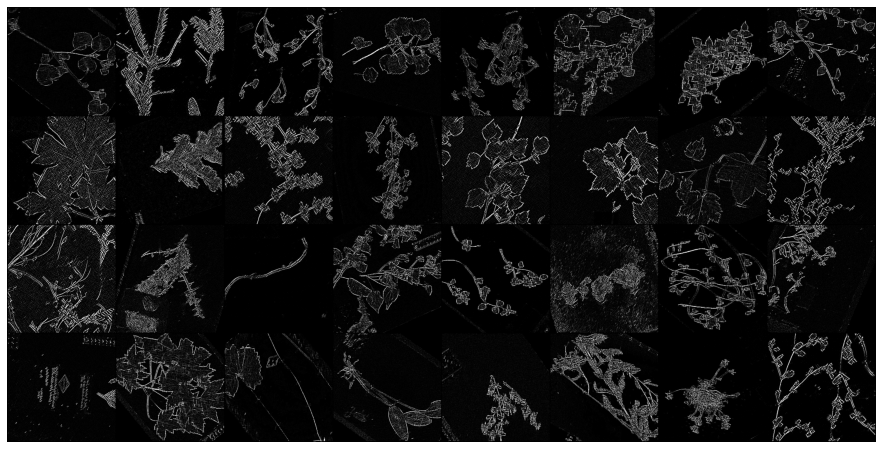

In [8]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
N_Classes = train_df['category'].nunique()

model = ResNet9(1, N_Classes)

if torch.cuda.is_available():
    model.cuda()   

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [15]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, model, criterion, optimizer, scaler, device=device)
    torch.save(model, './edge_dense.pth')
    eval_acc, eval_loss = evaluate(val_dl, model, criterion, device=device)
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

/Users/terry/miniconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
  0%|          | 0/4388 [00:00<?, ?it/s]/Users/terry/miniconda3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 366/366 [01:48<00:00,  3.38it/s]



Epoch 1 | Train Acc: 2.267547845840454 | Train Loss: 4.572979927062988
	 Val Acc: 2.868852376937866 | Val Loss: 4.328003406524658


100%|██████████| 366/366 [01:48<00:00,  3.38it/s]



Epoch 2 | Train Acc: 3.1734275817871094 | Train Loss: 4.235621929168701
	 Val Acc: 4.4398908615112305 | Val Loss: 4.027653694152832


100%|██████████| 366/366 [01:44<00:00,  3.51it/s]



Epoch 3 | Train Acc: 3.7260711193084717 | Train Loss: 4.077425956726074
	 Val Acc: 4.098360538482666 | Val Loss: 3.9543633460998535


100%|██████████| 366/366 [01:44<00:00,  3.52it/s]



Epoch 4 | Train Acc: 4.518003940582275 | Train Loss: 4.015643119812012
	 Val Acc: 4.2349724769592285 | Val Loss: 3.9274001121520996


100%|██████████| 366/366 [01:48<00:00,  3.38it/s]



Epoch 5 | Train Acc: 4.956699848175049 | Train Loss: 3.9697349071502686
	 Val Acc: 4.1666669845581055 | Val Loss: 4.037658214569092


 63%|██████▎   | 2777/4388 [27:23<15:53,  1.69it/s]
